# DQN 及其改进方法
## 简介
DQN算法敲开了用深度神经网络构建Q函数的大门，但是作为先驱性的工作，其本身也存在着一些问题以及一些可以改进的地方，于是在DQN之后学术界涌现出了非常多的改进算法。在本节课程中，我们将实现DQN的几个经典改进：Double DQN、Dueling DQN和multi-step learning，这几个算法实现简单但能一定程度改善DQN的效果。论文[1]中包含了DQN的常见改进以及效果比较，推荐同学们阅读。
**本次作业一共包含三个实验部分，需要同学们补全相应代码并运行保留实验结果。**

[1] Hessel, Matteo, et al. "[Rainbow: Combining improvements in deep reinforcement learning.](https://arxiv.org/abs/1710.02298)" arXiv preprint arXiv:1710.02298 (2017).

## 第一部分：Double DQN

传统的DQN算法通常会导致对Q值的过高估计。我们可以观察到，传统DQN优化的目标为
$$
r+\gamma \max _{a^{\prime}} Q_{\theta^-}\left(s', a^{\prime}\right)
$$
这个目标由目标网络（参数为$\theta^-$）计算得出，我们还可以将其写成如下形式

$$
Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s',  a' \right) \right)
$$

换句话说，max操作实际可以被拆解为两部分，首先选取状态$s'$下的最优动作$a^{*} = \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s', a' \right)$，接着计算该动作对应的Q值$Q\left(s', a^* \right)$。
当这两部分采用同一套Q网络进行计算时，每次得到的都是神经网络当前估算的所有动作Q值中的最大值。考虑到我们通过神经网络估算的Q值本身在某些时候会产生或正或负的误差，在DQN的更新方式下神经网络会将正误差累积。比如我们考虑一个特殊情形，在状态$s'$下所有动作的Q值均为0，即$Q(s', a_i)=0,\forall i$，此时正确的更新目标应为$r+0=r$。但是由于神经网络拟合的误差通常会出现某些动作的估算有正误差$Q(s', a_j) > 0$，此时我们的更新目标出现了过高估计，$r+\gamma \max Q \geq r$。当我们用DQN的更新公式进行更新时，$Q(s, a)$也就会被过高估计了。同理，我们拿这个$Q(s,a)$来作为更新目标来更新上一步的Q值时，同样会过高估计，并且误差将会逐步累积。


为了解决这一问题，[Double DQN](https://arxiv.org/abs/1509.06461)算法提出利用两个独立训练的神经网络估算$\max_{a'} Q_*(s', a')$。具体做法是将原有的$\max _{a^{\prime}} Q_{\theta^-}\left(s', a^{\prime}\right)$更改为

$$
Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta}\left(s',  a' \right) \right)
$$

即我们利用一套神经网络$Q_{\boldsymbol{\theta}}$选取动作，用另一套神经网络$Q_{\boldsymbol{\theta}^{-}}$计算该动作的Q值。这样，就算其中一套神经网络某个动作存在比较严重的过高估计，由于另一套神经网络的存在，这个动作最终使用的Q值不会存在很大的过高估计，从一定程度上解决了这个问题。

而我们注意到，在传统的DQN算法中，本来就存在两套Q函数的神经网络——目标网络和训练网络，只不过$\max_{a'} Q_{\theta^-}\left(s', a' \right)$的计算只用到了其中的目标网络，那么我们恰好可以直接将训练网络作为Double DQN算法中的第一套神经网络选取动作，将目标网络作为第二套神经网络计算Q值，这便是Double DQN的主要思想。
由于在DQN算法中我们就将训练网络的参数记为$\theta$，将目标网络的参数记为$\theta^{-}$，这与之前Double DQN中写下的两套神经网络的参数是统一的，我们可以直接写出如下Double DQN的优化目标

$$
r+\gamma Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_\theta\left(s', a'\right)\right)
$$



![Image Name](https://cdn.kesci.com/upload/image/qipg4vdji5.png?imageView2/0/w/960/h/960)

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;   图：Double DQN和DQN对比图


### Double DQN代码实践
显然，Double DQN与DQN的差别只是在于计算状态$s'$下Q值时动作的选取上：
* DQN的优化目标可以写为$r+\gamma Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s', a'\right)\right)$，动作的选取依靠目标网络$Q_{\theta^-}$
* Double DQN的优化目标为$r+\gamma Q_{\theta^-}\left(s, \underset{a'}{\operatorname{argmax}} Q_\theta\left(s', a' \right)\right)$，动作的选取依靠训练网络$Q_\theta$

所以代码实现可以直接在原DQN的基础上进行，无需做过多修改。

本次采用的环境是[Pendulum](https://gym.openai.com/envs/Pendulum-v0/)，该环境下有一个从随机位置开始的钟摆，钟摆向上保持直立时奖励为0，钟摆在其他位置时奖励为负数，环境本身没有终止状态。环境的状态为钟摆角度的正弦值$\sin \theta$，余弦值$\cos \theta$，角速度$\dot\theta$，动作为对钟摆施加的力矩。每一步会根据当前摆的状态的好坏给予不同的奖励。200步后自动结束游戏。在此环境下我们可以验证DQN对于Q值的过高估计——该环境下Q值的最大估计应为0(钟摆向上保持竖直时能选取的最大Q值)，Q值出现大于0的情况则说明出现了过高估计。
**注：由于Pendulum-v0环境的动作为一个代表力矩，在[-2,2]范围内的连续值，为了方便起见，我们采用离散化动作的方法。如下面的代码中我们将连续的动作空间离散为11个动作。动作0，1，..., 9, 10分别代表力矩为-2， -1.6， ..., 1.6, 2**

该环境的状态有三个参数：

标号 | 名称  | 最小值 | 最大值  
----|--------------|-----|----   
0   | $\cos \theta$  | -1.0| 1.0
1   | $\sin \theta$   | -1.0| 1.0
2   |$\dot\theta$  | -8.0| 8.0

该环境只有一类动作（连续动作）：

标号 | 动作  | 最小值 | 最大值  
----|--------------|-----|----   
0   | 力矩 | -2.0| 2.0



![Pendulum](https://cdn.kesci.com/upload/image/qfoepa3n0z.gif?imageView2/0/w/960/h/960)
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;   图：Pendulum环境示意图

In [15]:
import math
import random
import time

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Normal
from tqdm import tqdm

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
gamma = 0.98
# 注意此时的训练函数多了一个isDoubleDQN的参数
def learn(batch_size, current_model, target_model, replay_buffer, optimizer, isDoubleDQN, step=1):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    with torch.no_grad():
        state = torch.FloatTensor(np.float32(state)).to(device)
        next_state = torch.FloatTensor(np.float32(next_state)).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        done = torch.FloatTensor(done).to(device)

    q_values = current_model(state)
    next_q_values = current_model(next_state)
    next_q_values_target = target_model(next_state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # the only difference between Double DQN and DQN
    ########################################
    ## TODO【第一部分】: 计算DQN与DoubleDQN算法的更新目标，并更新网络
    ########################################
    if isDoubleDQN:
        argmax_q_action = next_q_values.max(1)[1].view(-1, 1)
        max_q_value = next_q_values_target.gather(1, argmax_q_action).squeeze(1)
    else:
        max_q_value = next_q_values_target.max(1)[0]
    
    q_target = reward + gamma * max_q_value * (1 - done)    
    loss = torch.mean(F.mse_loss(q_value, q_target))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [17]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

In [18]:
class DQN_base(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        raise NotImplementedError

    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
                q_value = self.forward(state)
                action = q_value.max(1).indices.item()
        else:
            action = random.randrange(discrete_action_n)
        return action

In [19]:
class DQN(DQN_base):
    def __init__(self, input_n, num_actions, h_size=24):
        super(DQN, self).__init__()

        self.input_n = input_n
        self.num_actions = num_actions

        self.fc = nn.Sequential(
            nn.Linear(self.input_n, h_size),
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            nn.Linear(h_size, self.num_actions)
        )
        

    def forward(self, x):
        x = self.fc(x)
        return x

In [20]:
env, env1 = None, None
discrete_action_n, input_n = 0, 0
faction = None

def set_env(env_id):
    global env, env1, discrete_action_n, input_n, faction
    env = gym.make(env_id)
    env1 = gym.make(env_id)
    input_n = env.observation_space.shape[0]
    if not isinstance(env.action_space, gym.spaces.discrete.Discrete):
        discrete_action_n = 11  # [0, discrete_action_n-1]
        action_lowbound = env.action_space.low[0]
        action_upbound = env.action_space.high[0]

        #discrete action to continuous action
        def faction(discrete_n):
            return action_lowbound + (discrete_n / (discrete_action_n - 1)) * (action_upbound - action_lowbound)
    else:
        discrete_action_n = env.action_space.n

# 如果报错，可以尝试Pendulum-v0，可能是由于gym版本不同导致
set_env("Pendulum-v1")

In [21]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [22]:
def smooth_curve(y, smooth):
    r = smooth
    length = int(np.prod(y.shape))
    for i in range(length):
        if i > 0:
            if (not np.isinf(y[i - 1])) and (not np.isnan(y[i - 1])):
                y[i] = y[i - 1] * r + y[i] * (1 - r)
    return y

def moving_average(y, x=None, total_steps=100, smooth=0.9, move_max=False):
    if isinstance(y, list):
        y = np.array(y)
    length = int(np.prod(y.shape))
    if x is None:
        x = list(range(1, length+1))
    if isinstance(x, list):
        x = np.array(x)
    if length > total_steps:
        block_size = length//total_steps
        select_list = list(range(0, length, block_size))
        select_list = select_list[:-1]
        y = y[:len(select_list) * block_size].reshape(-1, block_size)
        if move_max:
            y = np.max(y, -1)
        else:
            y = np.mean(y, -1)
        x = x[select_list]
    y = smooth_curve(y, smooth)
    return y, x
        
def plotMaxQ(max_Qs):
    y, x = moving_average(max_Qs)
    plt.xlabel("frame")
    plt.ylabel("Q value")
    plt.plot(x, y)
    plt.show()
def plotReward(all_rewards):
    y, x = moving_average(all_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(x, y)
    plt.show()

In [23]:
replay_initial = 1000
replay_buffer_size = 3000

    
num_frames = 20000
batch_size = 64
    
epsilon_start = 0.5
epsilon_final = 0.01
epsilon_decay = 1500
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
        -1. * frame_idx / epsilon_decay)
update_target_step = 100
learning_rate = 0.01
eval_step = 200
h_size=24

def push_buffer(buffers, sample ,step=1):
    wait_buffer, replay_buffer = buffers
    replay_buffer.push(*sample)
    ########################################
    ## TODO【第三部分】: 在完成多步学习时，
    ## 需要自行处理step>1的情况，
    ## Dueling DQN和DoubleDQN部分可以暂时忽略此处
    ########################################
    wait_buffer.append(sample)
    state, action, reward, next_state, done = sample
    if wait_buffer.__len__() == step:
        for i in reversed(range(step)):
            R = reward
            s, a, r, ss, d = wait_buffer[i]
            R = R * gamma + r
            if done and i > 0:
                replay_buffer.push(s, a, R, ss, d)
        state_n, action_n, reward_n, next_state_n, done_n = wait_buffer.pop(0)
        replay_buffer.push(state_n, action_n, R, next_state_n, done_n)
    return wait_buffer
    
def empty_buffer(buffers):
    wait_buffer, replay_buffer = buffers
    ########################################
    ## TODO:【第三部分】: 在完成多步学习时，
    ## 需要自行处理step>1的情况，
    ## Dueling DQN和DoubleDQN部分可以暂时忽略此处
    ########################################
    wait_buffer = []
    return wait_buffer
    
def evaluation(current_model):
    state = env1.reset()
    env1.seed(1)
    random.seed(1)
    done = False
    r = 0
    while not done:
        action = current_model.act(state, 0)
        if not isinstance(env.action_space, gym.spaces.discrete.Discrete):
            next_state, reward, done, _ = env1.step(np.array([faction(action)]))
        else:
            next_state, reward, done, _ = env1.step(action)
            
        state = next_state
        r += reward
    return r
    
def train(num_frames=num_frames, isDoubleDQN: bool=False, isDuelingDQN: bool=False, 
          DQN: DQN_base=None, DuelingDQN: DQN_base=None,
          multi_step=1):
    def maxQ(model, state):
        with torch.no_grad():
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
            q_value = model.forward(state)
            max_q_value = q_value.max(1).values.item()
        return max_q_value
    replay_buffer = ReplayBuffer(replay_buffer_size)
    
    wait_buffer = []
    
    if isDuelingDQN:
        current_model = DuelingDQN(input_n, discrete_action_n, h_size=h_size).to(device)
        target_model = DuelingDQN(input_n, discrete_action_n, h_size=h_size).to(device)
    else:
        current_model = DQN(input_n, discrete_action_n, h_size=h_size).to(device)
        target_model = DQN(input_n, discrete_action_n, h_size=h_size).to(device)
    update_target(current_model, target_model)
    
    optimizer = optim.Adam(current_model.parameters(), lr=learning_rate)
    
    max_Qs = []
    now_Q = 0
    all_rewards = []
    episode_reward = 0
    episode = 0

    state = env.reset()
    env.seed(1)
    random.seed(1)
    for frame_idx in tqdm(range(1, num_frames + 1)):
        t_episode_start = time.process_time()
        epsilon = epsilon_by_frame(frame_idx)
        action = current_model.act(state, epsilon)
        now_Q = maxQ(current_model, state)# to make the curve more smooth
        max_Qs.append(now_Q)
    
        if not isinstance(env.action_space, gym.spaces.discrete.Discrete):
            next_state, reward, done, _ = env.step(np.array([faction(action)]))
        else:
            next_state, reward, done, _ = env.step(action)
#         reward /= 10
        
#         replay_buffer.push(state, action, reward, next_state, done)
        wait_buffer = push_buffer((wait_buffer, replay_buffer), (state, action, reward, next_state, done), step=multi_step)
        
        episode_reward += reward
        state = next_state
        
        if done:
            state = env.reset()
            wait_buffer = empty_buffer((wait_buffer, replay_buffer))
            episode_reward = 0
            episode += 1
        
        if frame_idx % eval_step == 0:
            r = evaluation(current_model)
            all_rewards.append(r)
    
        if len(replay_buffer) >= replay_initial:
            learn(batch_size, current_model, target_model, replay_buffer, optimizer, isDoubleDQN=isDoubleDQN, step=multi_step)
    
        if frame_idx % update_target_step == 0:
            update_target(current_model, target_model)
        
    return max_Qs, all_rewards

In [24]:
max_Qs_doubleDQN, returns_doubleDQN = train(30000, isDoubleDQN = True, DQN=DQN)
max_Qs_regularDQN, returns_regularDQN = train(30000, isDoubleDQN = False, DQN=DQN)

100%|██████████| 30000/30000 [02:20<00:00, 213.33it/s]


In [25]:
def compareResult(rewards, labels, use_max=False, smooth=0.9, ylabel_name="Reward"):
    plt.ylabel(ylabel_name)
    plt.xlabel("Frame")
    for rs in rewards:
        if not use_max:
            x1 = list(range(0, len(rs)*eval_step, eval_step))
        else:
            x1 = None
        reward1, x1 = moving_average(rs, x1, move_max=use_max, smooth=smooth)
        plt.plot(x1, reward1)
    plt.legend(labels)
    plt.show()

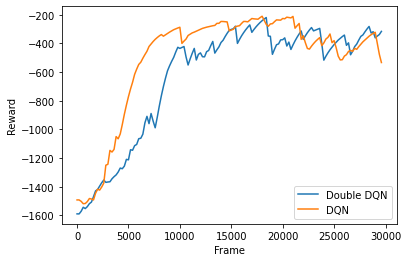

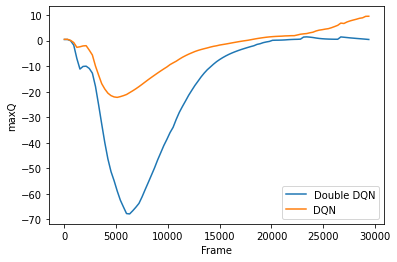

In [26]:
compareResult([returns_doubleDQN, returns_regularDQN], ["Double DQN", "DQN"])
compareResult([max_Qs_doubleDQN, max_Qs_regularDQN], ["Double DQN", "DQN"], use_max=True, ylabel_name="maxQ")

**【第一部分】 请完成以上double dqn代码，并运行得到reward的maxQ曲线**

MaxQ参考结果如下，代码正确，结果相对合理即可:
![Image Name](https://cdn.kesci.com/upload/image/r2lugyngv2.png?imageView2/0/w/960/h/960)
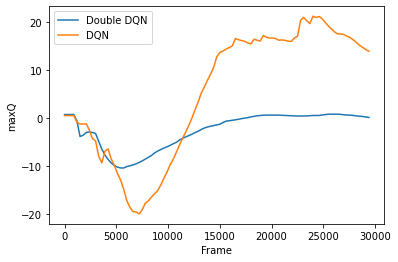

我们可以发现，相比于Double DQN，普通的DQN算法非常容易出现Q值大于0的情形（过高估计）

## 第二部分：Dueling DQN

[Dueling DQN](https://arxiv.org/abs/1511.06581)是另一种DQN的改进算法。它在传统DQN的基础上只进行了稍稍改动，但却能大幅提升DQN的表现。在强化学习中，我们将状态动作价值函数减去状态函数定义为优势函数，即$A(s,a) = Q(s,a)-V(s)$。在同一个状态下，所有动作的优势值之和为0，因为所有动作的动作价值的平均就是这个状态的状态价值。据此，在Dueling DQN中，Q网络被建模为：

$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+A(s, a ; \theta, \alpha)
$$

其中$V(s ; \theta, \beta)$为状态价值函数，而$A(s, a ; \theta, \alpha)$则为该状态下采取不同动作的优势函数，表征的是采取不同动作的差异性。$\theta$是状态价值函数和优势函数共享的网络参数，一般为神经网络用来提取特征的前几层。而$\alpha$和$\beta$为两者各自的参数。在这样的建模下我们不再让神经网络直接输出Q值，而是训练神经网络的两部分分别输出价值函数和优势函数，再求和得到Q值。DQN和Dueling DQN的网络结构图区别如下：

![DQN与Dueling DQN网络结构的区别](https://cdn.kesci.com/upload/image/qfmiegdc53.png?imageView2/0/w/320/h/320)
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;   图：DQN与Dueling DQN网络结构的区别

将状态价值函数和优势函数分别建模的好处在于某些情境下智能体只会关注状态的价值，而并不关心不同动作导致的差异，此时将二者分开建模能够使智能体更好地处理与动作关联较小的状态。如下图的驾驶车辆游戏中（通过显著区域（saliency map）技术，智能体注意力集中的部位被显示为偏橙色），在智能体前面没有车时，车子自身动作并没有太大差异，此时智能体更关注于状态价值，而在有车时（智能体需要超车），智能体开始关注不同动作优势值上的差异。


![Image Name](https://cdn.kesci.com/upload/image/r2nmoi8s0u.PNG?imageView2/0/w/960/h/960)

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;   图：状态价值和优势值的简单例子

对于上述Dueling DQN中的公式$Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+A(s, a ; \theta, \alpha)$，它存在对于$A$值和$V$值建模不唯一性的问题（比如对于同样的$Q$值，如果将$V$值加上任意大小的常数$C$，再将所有$A$值减去$C$，则我们得到的$Q$值依然不变，这就给训练造成了不稳定）。为了解决这一问题，原论文将强制将优势函数在实际行为的输出调整为$0$，即
$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+\left(A(s, a ; \theta, \alpha)-\max _{a^{\prime}} A\left(s, a^{\prime} ; \theta, \alpha\right)\right)
$$
此时可以确保$V$值建模的唯一性。
而在实际实现过程中，我们通常将优势函数在所有动作的输出期望设为$0$,即
$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+ 
\quad\left(A(s, a ; \theta, \alpha)-\frac{1}{|\mathcal{A}|} \sum_{a^{\prime}} A\left(s, a^{\prime} ; \theta, \alpha\right)\right)
$$
这样可以提高稳定性。在下面的代码实现中，我们将采取此种方式。

有读者可能问：为什么Dueling DQN会比DQN好？原论文里写道Dueling DQN能更高效学习状态价值函数。每一次更新时，V函数都会被更新到，这也会影响到其他动作的Q值；而传统的DQN只会更新某个动作的Q值，其他动作的Q值就不会更新。这样能够更加频繁准确的学习到状态价值函数。

### Dueling DQN代码实践
Dueling DQN与DQN相比的差异只是在网络结构上，大部分代码依然可以继续沿用，注意进行下方代码前要运行上方定义超参数的代码

In [30]:
# 注意此时多了一个参数isDuelingDQN
class DuelingDQN(DQN_base):
    def __init__(self, input_n, num_actions, h_size=64):
        super().__init__()

        self.input_n = input_n
        self.num_actions = num_actions
        self.base_net = nn.Sequential(
            nn.Linear(self.input_n, h_size),
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
        )
        
        # the difference
        ########################################
        ## TODO【第二部分】: 定义Dueling DQN的网络结构，建议参考上方DQN的网络结构所使用的超参数
        ## V和A两个网络可以共享前几层
        ########################################
        self.Vnet = nn.Linear(h_size, 1)
        self.Anet = nn.Linear(h_size, num_actions)

    def forward(self, x):
        x = self.base_net(x)
        # the difference
        ########################################
        ## TODO【第二部分】: 实现Dueling DQN输出Q的方法
        ########################################
        V = self.Vnet(x)
        A = self.Anet(x)
        A = A - A.mean(1).view(-1,1)
        x = V + A
        return x

In [31]:
_, returns_duelingDQN = train(30000, isDoubleDQN=False, isDuelingDQN=True, DQN=DQN, DuelingDQN=DuelingDQN)

100%|██████████| 30000/30000 [03:03<00:00, 163.93it/s]


In [32]:
_, returns_DQN = train(30000, isDoubleDQN=False, isDuelingDQN=False, DQN=DQN, DuelingDQN=DuelingDQN)

100%|██████████| 30000/30000 [02:22<00:00, 210.74it/s]


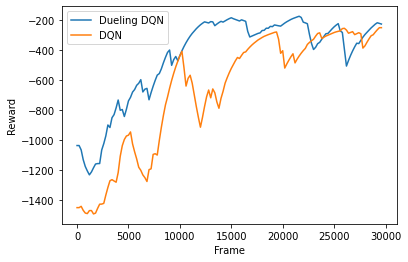

In [33]:
compareResult([returns_duelingDQN, returns_DQN], labels=['Dueling DQN', 'DQN'])

相比于传统的DQN，Dueling DQN相比于DQN在多个动作选择下的学习更加稳定，在目前情况下，dueling dqn的提升效果似乎不明显。
由Dueling DQN的原理可知随着动作空间的增大，Dueling DQN相比于DQN的优势更为明显。之前我们在环境中设置的离散动作为11个，如果将离散动作数增多（15， 25， ...），我们可以继续进行对比实验。

In [34]:
set_env("Pendulum-v1")
discrete_action_n = 25  # [0, discrete_action_n-1]
_, returns_duelingDQN = train(isDoubleDQN=False, isDuelingDQN=True, DQN=DQN, DuelingDQN=DuelingDQN)
_, returns_DQN = train(isDoubleDQN=False, isDuelingDQN=False, DQN=DQN, DuelingDQN=DuelingDQN)

100%|██████████| 20000/20000 [01:34<00:00, 210.92it/s]


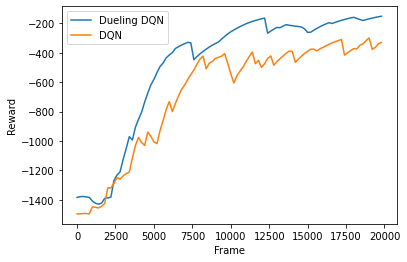

In [35]:
compareResult([returns_duelingDQN, returns_DQN], labels=['Dueling DQN', 'DQN'])

**【第二部分】请完成以上dueling dqn代码，并运行得到不同动作数量下的reward曲线。**
参考结果如下，代码正确，结果相对合理即可:


![Image Name](https://cdn.kesci.com/upload/image/r2lui4rxhk.png?imageView2/0/w/960/h/960)

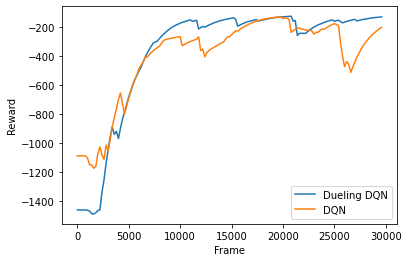

## 第三部分：多步学习
类似上次作业中的n-step SARSA算法，DQN算法也可以很自然地推广出多步形式。对于当前状态$S_t$，定义the truncated n-step return为
$$
R_t^{(n)} \equiv \sum_{k=0}^{n-1} \gamma^k r_{t+k+1}
$$
那么DQN的目标损失函数为
$$
L = (R_t^{(n)} + \gamma^n \max_{a'}Q_{\theta^-}(s_{t+n}, a') - Q_{\theta}(s_t, a_t))^2
$$
为了体现这一改进的效果，我们使用了[gym](https://gym.openai.com/envs/)中的另一个环境[CartPole](https://gym.openai.com/envs/CartPole-v0/)。
请尝试并比较不同步长时（如$n=1,3,5$）的结果。

**【第三部分】请自行修改train、push_buffer、empty_buffer函数，以支持多步学习（实现方法不限，合理即可）。运行试验并获得不同step下的reward曲线。**

In [36]:
set_env("CartPole-v0")

In [37]:
results = []
labels = []
for step_length in [1,3,5,7]:
    _, rs = train(30000, isDoubleDQN=False, isDuelingDQN=False, DQN=DQN, multi_step=step_length)
    results.append(rs)
    labels.append("step-{}".format(step_length))

100%|██████████| 30000/30000 [02:15<00:00, 221.10it/s]


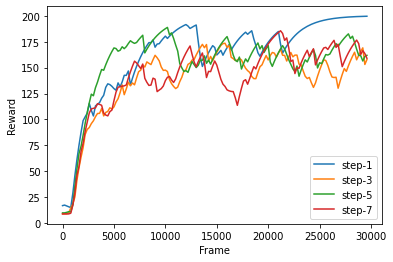

In [38]:
compareResult(results, labels)

## 总结
在传统的DQN基础上，有两种非常容易实现的变式——Double DQN和Dueling DQN，Double DQN解决了DQN中对Q值的过高估计，而Dueling DQN能够很好地学习到不同动作的差异性，在动作空间较大的环境下非常有效。同时，合适的Multi-step设置也可以对DQN效果有一定的提升。

## 扩展阅读： 对Q值过高估计的定量分析
我们可以对Q值的过估计做一个简化的定量分析。假设在状态$s$下所有动作的期望回报均无差异，即$Q_*(s,a) = V_*(s)$（此情形是为了定量分析所简化的情形，实际上不同动作的期望回报通常会存在差异）。假设神经网络估算误差$Q_{\theta^-}(s, a)-V_{*}$服从$[-1,1]$之间的均匀独立同分布。假设动作空间大小为$m$，那么对于任意状态$s$我们有
$$
\mathbb{E}\left[\max _{a} Q_{\theta^-}(s, a)- \max_{a'} Q_{*}(s,a')\right]=\frac{m-1}{m+1}
$$
**证明：**
我们将估算误差记为$\epsilon_{a}=Q_{\theta^-}(s, a)-\max_{a'}Q_{*}(s, a')$，由于估算误差对于不同的动作是独立的，我们有
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) =\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right)
\end{aligned}
$$
$P(\epsilon_a \leq x)$是$\epsilon_a$的累积分布函数（CDF）,它可以具体被写为
$$
P\left(\epsilon_{a} \leq x\right)=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\frac{1+x}{2} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
$$
因此，我们有关于$\max_a \epsilon_a$的累积密度函数(CDF)
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) &=\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right) \\
&=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\left(\frac{1+x}{2}\right)^{m} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
\end{aligned}
$$
最后我们可以得到
$$
\begin{aligned}
\mathbb{E}\left[\max _{a} \epsilon_{a}\right] &=\int_{-1}^{1} x \frac{\mathrm{d}}{\mathrm{d} x} P\left(\max _{a} \epsilon_{a} \leq x \right) \mathrm{d} x \\
&=\left[\left(\frac{x+1}{2}\right)^{m} \frac{m x-1}{m+1}\right]_{-1}^{1} \\
&=\frac{m-1}{m+1}
\end{aligned}
$$
虽然这一分析简化了实际环境，但它正确刻画了Q值过高估计的一些性质，比如Q值的过高估计随动作数目$m$的增加而增加，换而言之，在动作选择数更多的环境中Q值的过高估计会更严重。